In [29]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import random
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration, mass_defs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from pylab import rcParams
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams['font.family'] = 'serif'
rc('text.latex',preamble=r'\usepackage{/Volumes/Extreme_SSD/codes/master_thesis/code/configs/apjfonts}')
sz_ft = 20
sz_lb = 14
color_arr = ['indigo', 'royalblue', 'lightseagreen', 'darkgreen', 'goldenrod', 'darkred']
from tqdm import tqdm
import lensing_estimator
from cosmo import CosmoCalc
import lensing
import foregrounds as fg
import experiments as exp
import sims
import stats
import tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Estimator Validation

In [26]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 500
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.4)
l, nl = exp.white_noise_power_spectrum(noiseval_white = 2.0)
l, nl_deconvolved =  exp.white_noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.4)
cl_noise =  nl_deconvolved
nber_clus_fit = 30000
nber_rand_fit = 30000
mass_int_estimator_validation = np.arange(0, 12, 0.1)
c200c = 3
z = 1


covariance_matrix_estimator_validation, correlation_matrix_estimator_validation = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl, cl_noise = cl_noise)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_estimator_validation.npy', 'wb') as file:
    np.save(file, covariance_matrix_estimator_validation)   
        

model_profiles_estimator_validation = lensing_estimator.model_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_estimator_validation, c200c, z, bl = bl, cl_noise = cl_noise)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_estimator_validation.npy', 'wb') as file:
    np.save(file, model_profiles_estimator_validation)    

            
            
lk_arr_2e14 = []      
lk_arr_6e14 = []  
lk_arr_10e14 = []  
for i in tqdm(range(25)):    
    maps_2e14, maps_6e14, maps_10e14 = sims.cmb_test_data(nber_clus, validation_analyis = True)
    maps_rand = []
    for j in range(nber_rand):    
        map_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl)
        maps_rand.append(map_rand)
    bins_2e14, lensing_dipole_profile_2e14, stacks_2e14 = lensing_estimator.lensing_dipole_profile(map_params, maps_2e14, maps_rand, l = l, cl = cl, cl_noise = cl_noise)
    bins_6e14, lensing_dipole_profile_6e14, stacks_6e14 = lensing_estimator.lensing_dipole_profile(map_params, maps_6e14, maps_rand, l = l, cl = cl, cl_noise = cl_noise)
    bins_10e14, lensing_dipole_profile_10e14, stacks_10e14 = lensing_estimator.lensing_dipole_profile(map_params, maps_10e14, maps_rand, l = l, cl = cl, cl_noise = cl_noise)
    data_2e14 = bins_2e14, lensing_dipole_profile_2e14, covariance_matrix_estimator_validation
    data_6e14 = bins_6e14, lensing_dipole_profile_6e14, covariance_matrix_estimator_validation
    data_10e14 = bins_10e14, lensing_dipole_profile_10e14, covariance_matrix_estimator_validation
   

    likelihood_2e14, _, _ = stats.run_ml(data_2e14, model_profiles_estimator_validation, mass_int_estimator_validation)
    mass_int_lk_2e14, lk_2e14 = likelihood_2e14
    likelihood_6e14, _, _ = stats.run_ml(data_6e14, model_profiles_estimator_validation, mass_int_estimator_validation)
    mass_int_lk_6e14, lk_6e14 = likelihood_6e14
    likelihood_10e14, _, _ = stats.run_ml(data_10e14, model_profiles_estimator_validation, mass_int_estimator_validation)
    mass_int_lk_10e14, lk_10e14 = likelihood_10e14
    lk_arr_2e14.append(lk_2e14)
    lk_arr_6e14.append(lk_6e14)
    lk_arr_10e14.append(lk_10e14)

    del maps_2e14
    del maps_6e14
    del maps_10e14
    del maps_rand
    
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_2e14.npy', 'wb') as file:
    np.save(file, lk_arr_2e14) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_6e14.npy', 'wb') as file:
    np.save(file, lk_arr_6e14) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_10e14.npy', 'wb') as file:
    np.save(file, lk_arr_10e14) 

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:98: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))
  0%|          | 0/250 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [27]:
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_2e14.npy', 'rb') as file:
    lk_arr_2e14 = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_6e14.npy', 'rb') as file:
    lk_arr_6e14 = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_10e14.npy', 'rb') as file:
    lk_arr_10e14 = np.load(file) 
    
    
comb_lk_2e14 = np.ones(len(lk_arr_2e14[0]))
for i in range(1):
    comb_lk_2e14 *= lk_arr_2e14[i]
comb_lk_2e14 = comb_lk_2e14/max(comb_lk_2e14)
median_value, error = stats.ml_params(mass_int_lk_2e14, comb_lk_2e14)      
print(median_value, error) 

comb_lk_6e14 = np.ones(len(lk_arr_6e14[0]))
for i in range(1):
    comb_lk_6e14 *= lk_arr_6e14[i]
comb_lk_6e14 = comb_lk_6e14/max(comb_lk_6e14)
median_value, error = stats.ml_params(mass_int_lk_6e14, comb_lk_6e14)      
print(median_value, error) 
      
comb_lk_10e14 = np.ones(len(lk_arr_10e14[0]))
for i in range(1):
    comb_lk_10e14 *= lk_arr_10e14[i]
comb_lk_10e14 = comb_lk_10e14/max(comb_lk_10e14)
median_value, error = stats.ml_params(mass_int_lk_10e14, comb_lk_10e14)      
print(median_value, error)   

2.0142700806054474 0.04254145162584844
2.785482382816779 0.014779205101926207
2.785476618783619 0.014761813708857652


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


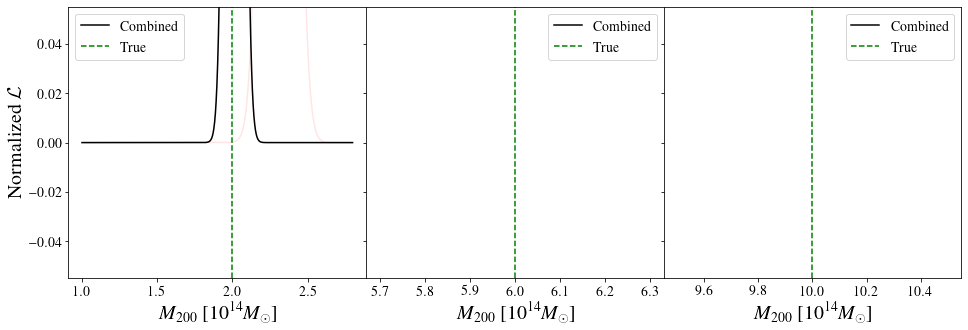

In [32]:
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(16,5))
(ax1, ax2, ax3) = axs
for i in range(2):
    ax1.plot(mass_int_lk_2e14, lk_arr_2e14[i], color = 'red', ls='-', alpha = 0.1)
ax1.plot(mass_int_lk_2e14, comb_lk_2e14, color = 'black', ls = '-', label = 'Combined')
ax1.tick_params(labelsize = sz_lb)
ax1.axvline(2, color = 'green', ls = '--', label = 'True') 
ax1.set_xlabel(r'$M_{200}\ [10^{14}M_\odot]$', fontsize = sz_ft)   
ax1.set_ylabel('Normalized '+r'$\mathcal{L}$', fontsize = sz_ft)
ax1.legend(prop={'size': sz_lb}) 
for i in range(2):
    ax2.plot(mass_int_lk_6e14[4500:7500], lk_arr_6e14[i][4500:7500], color = 'red', ls='-', alpha = 0.1)
ax2.plot(mass_int_lk_6e14[4500:7500], comb_lk_6e14[4500:7500], color = 'black', ls = '-', label = 'Combined')
ax2.tick_params(labelsize = sz_lb)
ax2.axvline(6, color = 'green', ls = '--', label = 'True') 
ax2.set_xlabel(r'$M_{200}\ [10^{14}M_\odot]$', fontsize = sz_ft) 
ax2.legend(prop={'size': sz_lb}) 
for i in range(2):
    ax3.plot(mass_int_lk_10e14[8000:12000], lk_arr_10e14[i][8000:12000], color = 'red', ls='-', alpha = 0.1)
ax3.plot(mass_int_lk_10e14[8000:12000], comb_lk_10e14[8000:12000], color = 'black', ls = '-', label = 'Combined')
ax3.tick_params(labelsize = sz_lb)
ax3.axvline(10, color = 'green', ls = '--', label = 'True') 
ax3.set_xlabel(r'$M_{200}\ [10^{14}M_\odot]$', fontsize = sz_ft) 
ax3.legend(prop={'size': sz_lb}) 

plt.savefig('estimator_validation.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

## Ignoring Noise for Fit Profiles

In [ ]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 500
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.4)
l, nl = exp.white_noise_power_spectrum(noiseval_white = 2.0)
l, nl_deconvolved =  exp.white_noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.4)
cl_noise =  nl_deconvolved
nber_clus_fit = 30000
nber_rand_fit = 30000
mass_int_estimator_validation = np.arange(0, 12, 0.1)
mass_int_estimator_validation_no_noise = np.arange(4, 8, 0.1)
c200c = 3
z = 1
           


with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_estimator_validation.npy', 'rb') as file:
    covariance_matrix_estimator_validation = np.load(file)        
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_estimator_validation.npy', 'rb') as file:
    model_profiles_estimator_validation = np.load(file)  

model_profiles_estimator_validation_no_noise = lensing_estimator.model_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_estimator_validation_no_noise, c200c, z, bl = bl, cl_noise = cl_noise, apply_noise = False)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_estimator_validation_no_shift.npy', 'wb') as file:
    np.save(file, model_profiles_estimator_validation_no_noise)    

    
lk_arr_baseline = []      
lk_arr_no_noise = []   
for i in tqdm(range(25)):    
    _, maps_6e14, _ = sims.cmb_test_data(nber_clus, validation_analyis = True)
    maps_rand = []
    for j in range(nber_rand):    
        map_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl)
        maps_rand.append(map_rand)
    bins_6e14, lensing_dipole_profile_6e14, stacks_6e14 = lensing_estimator.lensing_dipole_profile(map_params, maps_6e14, maps_rand, l = l, cl = cl, cl_noise = cl_noise)
    data_6e14 = bins_6e14, lensing_dipole_profile_6e14, covariance_matrix_estimator_validation

    likelihood_baseline, _, _ = stats.run_ml(data_6e14, model_profiles_estimator_validation, mass_int_estimator_validation)
    mass_int_lk_baseline, lk_baseline = likelihood_baseline
    likelihood_no_noise, _, _ = stats.run_ml(data_6e14, model_profiles_estimator_validation_no_noise, mass_int_estimator_validation_no_noise)
    mass_int_lk_no_noise, lk_no_noise = likelihood_no_noise
    lk_arr_baseline.append(lk_baseline)
    lk_arr_no_noise.append(lk_no_noise)

    del maps_6e14
    del maps_rand
    
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_baseline.npy', 'wb') as file:
    np.save(file, lk_arr_baseline) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_no_noise.npy', 'wb') as file:
    np.save(file, lk_arr_no_noise) 

In [ ]:
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_baseline.npy', 'rb') as file:
    lk_arr_baseline = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_no_noise.npy', 'rb') as file:
    lk_arr_no_noise = np.load(file) 
    
    
    
comb_lk_baseline = np.ones(len(lk_arr_baseline[0]))
for i in range(25):
    comb_lk_baseline *= lk_arr_baseline[i]
comb_lk_baseline = comb_lk_baseline/max(comb_lk_baseline)
median_value, error = stats.ml_params(mass_int_lk_baseline, comb_lk_baseline)      
print(median_value, error) 

comb_lk_no_noise = np.ones(len(lk_arr_no_noise[0]))
for i in range(25):
    comb_lk_no_noise *= lk_arr_no_noise[i]
comb_lk_no_noise = comb_lk_no_noise/max(comb_lk_no_noise)
median_value, error = stats.ml_params(mass_int_lk_no_noise, comb_lk_no_noise)      
print(median_value, error)   

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

for i in range(25):
    ax.plot(mass_int_lk_baseline[1000:3000], lk_arr_baseline[i][1000:3000], color = 'green', ls='-', alpha = 0.1)
    ax.plot(mass_int_lk_no_noise[4500:7500], lk_arr_no_noise[i][4500:7500], color = 'red', ls='-', alpha = 0.1)
ax.plot(mass_int_lk_baseline[1000:3000], comb_lk_baseline[1000:3000], color = 'darkgreen', ls = '-')
ax.plot(mass_int_lk_no_noise[1000:3000], comb_lk_no_noise[1000:3000], color = 'darkred', ls = '-')
ax.axvline(6, color = 'green', ls = '--') 
ax.set_xlabel(r'$M_{200}\ [10^{14}M_\odot]$', fontsize = 15)   
ax.set_ylabel('Normalized '+r'$\mathcal{L}$', fontsize = 15)

plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/estimator_validation_ignoring_noise.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

## Estimator Comparison 

In [ ]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 500
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
cluster = [2e14, 3, 0.7]
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.0)
l, nl1 = exp.white_noise_power_spectrum(noiseval_white = 0.1)
l, nl2 = exp.white_noise_power_spectrum(noiseval_white = 0.5)
l, nl3 = exp.white_noise_power_spectrum(noiseval_white = 1.0)
l, nl4 = exp.white_noise_power_spectrum(noiseval_white = 3.0)
l, nl_deconvolved1 =  exp.white_noise_power_spectrum(noiseval_white = 0.1, beam_fwhm = 1.0)
l, nl_deconvolved2 =  exp.white_noise_power_spectrum(noiseval_white = 0.1, beam_fwhm = 1.0)
l, nl_deconvolved3 =  exp.white_noise_power_spectrum(noiseval_white = 0.1, beam_fwhm = 1.0)
l, nl_deconvolved4 =  exp.white_noise_power_spectrum(noiseval_white = 0.1, beam_fwhm = 1.0)
cl_noise1 =  nl_deconvolved1
cl_noise2 =  nl_deconvolved2
cl_noise3 =  nl_deconvolved3
cl_noise4 =  nl_deconvolved4
nber_clus_fit = 30000
nber_rand_fit = 30000
mass_int_estimator_comparison = np.arange(0, 4, 0.1)
c200c = 3
z = 0.7


covariance_matrix_estimator_comparison1, correlation_matrix_estimator_comparison1 = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl1, cl_noise = cl_noise1)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_estimator_comparison_0.1.npy', 'wb') as file:
    np.save(file, covariance_matrix_estimator_comparison1)  
        
covariance_matrix_estimator_comparison2, correlation_matrix_estimator_comparison2 = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl2, cl_noise = cl_noise2)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_estimator_comparison_0.5.npy', 'wb') as file:
    np.save(file, covariance_matrix_estimator_comparison2)  
    
covariance_matrix_estimator_comparison3, correlation_matrix_estimator_comparison3 = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl3, cl_noise = cl_noise3)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_estimator_comparison_1.0.npy', 'wb') as file:
    np.save(file, covariance_matrix_estimator_comparison3)  

covariance_matrix_estimator_comparison4, correlation_matrix_estimator_comparison4 = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl4, cl_noise = cl_noise4)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_estimator_comparison_3.0.npy', 'wb') as file:
    np.save(file, covariance_matrix_estimator_comparison4)  


model_profiles_estimator_comparison1 = lensing_estimator.model_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_estimator_comparison, c200c, z, bl = bl, cl_noise = cl_noise1)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_estimator_comparison_0.1.npy', 'wb') as file:
    np.save(file, model_profiles_estimator_comaprison1)    

model_profiles_estimator_comparison2 = lensing_estimator.model_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_estimator_comparison, c200c, z, bl = bl, cl_noise = cl_noise2)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_estimator_comparison_0.5.npy', 'wb') as file:
    np.save(file, model_profiles_estimator_comaprison2)   
    
model_profiles_estimator_comparison3 = lensing_estimator.model_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_estimator_comparison, c200c, z, bl = bl, cl_noise = cl_noise3)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_estimator_comparison_1.0.npy', 'wb') as file:
    np.save(file, model_profiles_estimator_comaprison3)   
    
model_profiles_estimator_comparison4 = lensing_estimator.model_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_estimator_comparison, c200c, z, bl = bl, cl_noise = cl_noise4)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_estimator_comparison_3.0.npy', 'wb') as file:
    np.save(file, model_profiles_estimator_comaprison4)   
       


for i in tqdm(range(1)):    
    maps_clus1 = []
    for j in range(nber_clus):    
        map_clus = sims.cmb_mock_data(map_params, l, cl, cluster = cluster bl = bl, nl = nl1)
        maps_clus1.append(map_clus)    
    maps_rand1 = []
    for j in range(nber_rand):    
        map_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl1)
        maps_rand1.append(map_rand)
    bins1, lensing_dipole_profile1, stacks1 = lensing_estimator.lensing_dipole_profile(map_params, maps_clus1, maps_rand1,  l = l, cl = cl, cl_noise = cl_noise1)
    data1 = bins1, lensing_dipole_profile1, covariance_matrix_estimator_comparison1
    likelihood1, median_mass1, error1 = stats.run_ml(data1, model_profiles_estimator_comparison1, mass_int_estimator_comparison)
    del maps_clus1
    del maps_rand1
    
    maps_clus2 = []
    for j in range(nber_clus):    
        map_clus = sims.cmb_mock_data(map_params, l, cl, cluster = cluster bl = bl, nl = nl2)
        maps_clus2.append(map_clus)    
    maps_rand2 = []
    for j in range(nber_rand):    
        map_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl2)
        maps_rand2.append(map_rand)
    bins2, lensing_dipole_profile2, stacks2 = lensing_estimator.lensing_dipole_profile(map_params, maps_clus2, maps_rand2,  l = l, cl = cl, cl_noise = cl_noise2)
    data2 = bins2, lensing_dipole_profile2, covariance_matrix_estimator_comparison2
    likelihood2, median_mass2, error2 = stats.run_ml(data2, model_profiles_estimator_comparison2, mass_int_estimator_comparison)
    del maps_clus2
    del maps_rand2  
  
    maps_clus3 = []
    for j in range(nber_clus):    
        map_clus = sims.cmb_mock_data(map_params, l, cl, cluster = cluster bl = bl, nl = nl3)
        maps_clus3.append(map_clus)    
    maps_rand3 = []
    for j in range(nber_rand):    
        map_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl3)
        maps_rand3.append(map_rand)
    bins3, lensing_dipole_profile3, stacks3 = lensing_estimator.lensing_dipole_profile(map_params, maps_clus3, maps_rand3,  l = l, cl = cl, cl_noise = cl_noise3)
    data3 = bins3, lensing_dipole_profile3, covariance_matrix_estimator_comparison3
    likelihood3, median_mass3, error3 = stats.run_ml(data3, model_profiles_estimator_comparison3, mass_int_estimator_comparison)
    del maps_clus3
    del maps_rand3
    
    maps_clus4 = []
    for j in range(nber_clus):    
        map_clus = sims.cmb_mock_data(map_params, l, cl, cluster = cluster bl = bl, nl = nl4)
        maps_clus4.append(map_clus)    
    maps_rand4 = []
    for j in range(nber_rand):    
        map_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl4)
        maps_rand4.append(map_rand)
    bins4, lensing_dipole_profile4, stacks4 = lensing_estimator.lensing_dipole_profile(map_params, maps_clus4, maps_rand4,  l = l, cl = cl, cl_noise = cl_noise4)
    data4 = bins4, lensing_dipole_profile4, covariance_matrix_estimator_comparison4
    likelihood4, median_mass4, error4 = stats.run_ml(data4, model_profiles_estimator_comparison4, mass_int_estimator_comparison)
    del maps_clus4
    del maps_rand4
    
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_result_estimator_comparison_0.1.npy', 'wb') as file:
    np.save(file, median_mass1)
    np.save(file, error1)
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_result_estimator_comparison_0.5.npy', 'wb') as file:
    np.save(file, median_mass2)
    np.save(file, error2)
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_result_estimator_comparison_1.0.npy', 'wb') as file:
    np.save(file, median_mass3)
    np.save(file, error3) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_result_estimator_comparison_3.0.npy', 'wb') as file:
    np.save(file, median_mass4)
    np.save(file, error4)  

In [ ]:
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_result_estimator_comparison_0.1.npy', 'rb') as file:
    median_mass1 = np.load(file)
    error1 = np.load(file)
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_result_estimator_comparison_0.5.npy', 'rb') as file:
    median_mass2 = np.load(file)
    error2 = np.load(file)
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_result_estimator_comparison_1.0.npy', 'rb') as file:
    median_mass3 = np.load(file)
    error3 = np.load(file)
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_result_estimator_comparison_3.0.npy', 'rb') as file:
    median_mass4 = np.load(file)
    error4 = np.load(file)
    
noise_arr = [0.1, 0.5, 1.0, 3.0]
frac_mass_unc = [error1/median_mass1, error2/median_mass2, error3/median_mass3, error4/median_mass4]

In [ ]:
fig, ax = plt.subplots( figsize=(9,9))

color_arr = ['indigo', 'royalblue', 'lightseagreen', 'darkgreen']

ax.plot(noise_arr, frac_mass_unc,  color = color_arr[0], label = 'This Work')
ax.set_xlabel(r'$\Delta T\ [\mu$'+'K]$', fontsize = sz_ft)
ax.set_ylabel(r'$\Delta M/M$', fontsize = sz_ft
ax.tick_params(labelsize = sz_lb)
ax.legend(prop={'size': sz_lb}) 

fig.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/estimator_comparison.eps', bbox_inches = 'tight')

## Cluster Positions

In [ ]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 500
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.4)
l, nl = exp.white_noise_power_spectrum(noiseval_white = 2.0)
l, nl_deconvolved =  exp.white_noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.4)
cl_noise =  nl_deconvolved
nber_clus_fit = 30000
nber_rand_fit = 30000
centroid_shift_value = 0.5
mass_int_baseline = np.arange(0, 12, 0.1)
mass_int_centroid_shift = np.arange(4, 8, 0.1) 
c200c = 3
z = 1



with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_estimator_validation.npy', 'rb') as file:
    covariance_matrix = np.load(file) 
        

with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_estimator_validation.npy', 'rb') as file:
    model_profiles_baseline = np.load(file)          
        
model_profiles_centroid_shift = lensing_estimator.model_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_estimator_validation, c200c, z, centroid_shift_value = centroid_shift_value, bl = bl, cl_noise = cl_noise)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_centroid_shift.npy', 'wb') as file:
    np.save(file, model_profiles_centroid_shift)     

    
    
lk_arr_no_shift, mass_arr_no_shift, error_arr_no_shift = [], [], []    
lk_arr_ignoring_shift, mass_arr_ignoring_shift, error_arr_ignoring_shift = [], [], []
lk_arr_centroid_shift, mass_arr_centroid_shift, error_arr_centroid_shift = [], [], []   
for i in tqdm(range(25)):    
    maps_clus_no_shift, maps_clus_centroid_shift = sims.cmb_test_data(nber_clus, clus_position_analysis = True)
    maps_rand = []
    for j in range(nber_rand):    
        map_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl)
        maps_rand.append(map_rand)
                                                                               
    bins_no_shift, lensing_dipole_profile_no_shift, stacks_no_shift = lensing_estimator.lensing_dipole_profile(map_params, maps_clus_no_shift, maps_rand,  l = l, cl = cl, cl_noise = cl_noise)
    bins_centroid_shift, lensing_dipole_profile_centroid_shift, stacks_centroid_shift = lensing_estimator.lensing_dipole_profile(map_params, maps_clus_centroid_shift, maps_rand, l = l, cl = cl, cl_noise = cl_noise)
    data_no_shift = bins_no_shift, lensing_dipole_profile_no_shift, covariance_matrix
    data_centroid_shift = bins_centroid_shift, lensing_dipole_profile_centroid_shift, covariance_matrix

    likelihood_no_shift, median_mass_no_shift, error_no_shift = stats.run_ml(data_no_shift, model_profiles_baseline, mass_int_baseline)
    likelihood_ignoring_shift, median_mass_ignoring_shift, error_ignoring_shift = stats.run_ml(data_centroid_shift, model_profiles_baseline, mass_int_baseline)
    likelihood_centroid_shift, medan_mass_centroid_shift, error_centroid_shift = stats.run_ml(data_centroid_shift, model_profiles_centroid_shift, mass_int_centroid_shift)
    mass_int_lk_no_shift, lk_no_shift = likelihood_no_shift
    mass_int_lk_ignoring_shift, lk_ignoring_shift = likelihood_ignoring_shift
    mass_int_lk_centroid_shift, lk_centroid_shift = likelihood_centroid_shift
    lk_arr_no_shift.append(lk_no_shift)
    lk_arr_ignoring_shift.append(lk_ignoring_shift)
    lk_arr_centroid_shift.append(lk_centroid_shift)
    mass_arr_no_shift.append(median_mass_no_shift)
    mass_arr_ignoring_shift.append(median_mass_ignoring_shift)
    mass_arr_centroid_shift.append(median_mass_centroid_shift)
    error_arr_no_shift.append(error_no_shift)
    error_arr_ignoring_shift.append(errors_ignoring_shift)
    error_arr_centroid_shift.append(errors_centroid_shift)
   
    
    
    del maps_clus_no_shift
    del maps_clus_centroid_shift
    del maps_rand

    
with open('mass_arr_no_shift.npy', 'wb') as file:
    np.save(file, mass_arr_no_shift) 
    
with open('mass_arr_ignoring_shift.npy', 'wb') as file:
    np.save(file, mass_arr_ignoring_shift) 
    
with open('mass_arr_centroid_shift.npy', 'wb') as file:
    np.save(file, mass_arr_centroid_shift) 

with open('error_arr_no_shift.npy', 'wb') as file:
    np.save(file, error_arr_no_shift) 
    
with open('error_arr_ignoring_shift.npy', 'wb') as file:
    np.save(file, error_arr_ignoring_shift) 
    
with open('mass_arr_centroid_shift.npy', 'wb') as file:
    np.save(file, error_arr_centroid_shift)

In [ ]:
with open('mass_arr_no_shift.npy', 'rb') as file:
    mass_arr_no_shift = np.load(file) 
    
with open('mass_arr_ignoring_shift.npy', 'rb') as file:
    mass_arr_ignoring_shift = np.load(file) 
    
with open('mass_arr_centroid_shift.npy', 'rb') as file:
    mass_arr_centroid_shift = np.load(file) 

with open('error_arr_no_shift.npy', 'rb') as file:
    error_arr_ignoring_shift = np.load(file) 
    
with open('error_arr_ignoring_shift.npy', 'rb') as file:
    error_arr_ignoring_shift = np.load(file) 
    
with open('mass_arr_centroid_shift.npy', 'rb') as file:
    error_arr_centroid_shift = np.load(file)
    
    
comb_lk_no_shift = np.ones(len(lk_arr_no_shift[0]))
for i in range(25):
    comb_lk_no_shift *= lk_arr_no_shift[i]
comb_lk_no_shift = comb_lk_no_shift/max(comb_lk_no_shift)
mean_mass_comb_no_shift, error_comb_no_shift = stats.ml_params(mass_int_lk_no_shift, comb_lk_no_shift)      
print(mean_mass_comb_no_shift, error_comb_no_shift)     
    

comb_lk_ignoring_shift = np.ones(len(lk_arr_ignoring_shift[0]))
for i in range(25):
    comb_lk_ignoring_shift *= lk_arr_ignoring_shift[i]
comb_lk_ignoring_shift = comb_lk_ignoring_shift/max(comb_lk_ignoring_shift)
mean_mass_comb_ignoring_shift, error_comb_ignoring_shift = stats.ml_params(mass_int_lk_ignoring_shift, comb_lk_ignoring_shift)      
print(mean_mass_comb_ignoring, errors_comb_ignoring_shift) 


comb_lk_centroid_shift = np.ones(len(lk_arr_centroid_shift[0]))
for i in range(25):
    comb_lk_centroid_shift *= lk_arr_centroid_shift[i]
comb_lk_centroid_shift = comb_lk_centroid_shift/max(comb_lk_centroid_shift)
mean_mass_comb_centroid_shift, error_comb_centroid_shift = stats.ml_params(mass_int_lk_centroid_shift, comb_lk_centroid_shift)      
print(mean_mass_comb_centroid_shift, errors_comb_centroid_shift) 

In [ ]:
fig, ax = plt.subplots()
best_fit_arr = [mass_arr_no_shift, mass_arr_ignoring, mass_arr_centroid_shift]
centers_no_shift = np.asarray(mass_arr_no_shift)-6
centers_ignoring = np.asarray(mass_arr_ignoring)-6
centers_centroid_shift = np.asarray(mass_arr_centroid_shift)-6
centers = [centers_no_shift, centers_ignoring, centers_centroid_shift]
width_arr = [error_arr_no_shift, error_arr_ignoring, error_arr_centroid_shift]
color_arr = ['black', 'red', 'blue']
for cntr, (center, widthval, colorval) in enumerate(zip(centers, width_arr, color_arr )):
    yval = [cntr for i in range(len(mass_arr_no_shift))]
    plt.errorbar(center, yval, xerr = widthval, color = colorval, marker = 'o', ls = '', alpha = 0.05)
plt.errorbar(mean_mass_comb_no_shift-6, 0, xerr = (errors_comb_no_shift[0]+errors_comb_no_shift[1])/2, color = 'black', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_ignoring-6, 1, xerr = (errors_comb_ignoring[0]+errors_ignoring[1])/2, color = 'red', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_centroid_shift-6, 2, xerr = (errors_comb_centroid_shift[0]+errors_centroid_shift[1])/2, color = 'blue', marker = 'o', ls = '')
plt.axvline(0, color = 'green', ls = '--')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axes.yaxis.set_ticks([])
plt.text(0.6, 0, 'baseline', fontsize = 15)
plt.text(0.6, 1, '+ 0.5\' shift', fontsize = 15)
plt.text(0.6, 2, 'corrected', fontsize = 15)
plt.xlabel(r'$M_{lens}-M_{true}$', fontsize = 15)
plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/cluster_positions.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

## Foreground Bias

In [ ]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 250
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, c200 = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
fname = 'sim_data/mdpl2_cutouts_for_tszksz_clus_detection_M1.7e+14to2.3e+14_z0.6to0.8_15320haloes_boxsize20.0am.npz'
cutouts_dic = np.load(fname, allow_pickle = 1, encoding= 'latin1')['arr_0'].item()
mass_z_key = list(cutouts_dic.keys())[0]
cutouts = cutouts_dic[mass_z_key]
scale_fac = fg.compton_y_to_delta_Tcmb(freq = 150, uK = True)
tsz_cutouts, ksz_cutouts, tsz_ksz_cutouts = [], [], []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout = cutouts[keyname]['y']*scale_fac
    tsz_cutouts.append(tsz_cutout)
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    ksz_cutouts.append(ksz_cutout)
    tsz_ksz_cutout = tsz_cutout + ksz_cutout
    tsz_ksz_cutouts.append(tsz_ksz_cutout)   
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.4)
l, nl = exp.noise_power_spectrum(noiseval_white = 2.0)
l, nl_deconvolved =  exp.noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.4)
cl_noise =  nl_deconvolved
nber_clus_fit = 30000 
nber_rand_fit = 30000
mass_int_bias = np.arange(0, 6, 0.2) 
           

#covariance_matrix, correlation_matrix = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params,  l, cl, bl = bl, nl = nl, cl_noise = cl_noise)
with open('covariance_matrix.npy', 'rb') as file:
    covariance_matrix = np.load(file)   
        

        
#covariance_matrix_tsz, correlation_matrix_tsz = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params, l, cl, tsz_cutouts, bl = bl, nl = nl, cl_noise = cl_noise)      
with open('covariance_matrix_tsz.npy', 'rb') as file:
    covariance_matrix_tsz = np.load(file)
    
    
#covariance_matrix_ksz, correlation_matrix_ksz = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params, l, cl, ksz_cutouts, bl = bl, nl = nl, cl_noise = cl_noise)      
with open('covariance_matrix_ksz.npy', 'rb') as file:
    covariance_matrix_ksz = np.load(file)    
    
    
#covariance_matrix_tsz_ksz, correlation_matrix_tsz_ksz = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params, l, cl, tsz_ksz_cutouts, bl = bl, nl = nl, cl_noise = cl_noise)      
with open('covariance_matrix_tsz_ksz.npy', 'rb') as file:
    covariance_matrix_tsz_ksz = np.load(file)       
    

#covariance_matrix_tsz_corrected, correlation_matrix_tsz_corrected = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params, l, cl, tsz_cutouts, bl = bl, nl = nl, cl_noise = cl_noise, correct_for_tsz = True)      
with open('covariance_matrix_tsz_corrected.npy', 'rb') as file:
    covariance_matrix_tsz_corrected = np.load(file)
    
    
#covariance_matrix_tsz_ksz_corrected, correlation_matrix_tsz_ksz_corrected = lensing_estimator.covariance_matrix(nber_clus, nber_rand, nber_cov, map_params, l, cl, tsz_ksz_cutouts, bl = bl, nl = nl, cl_noise = cl_noise, correct_for_tsz = True)      
with open('covariance_matrix_tsz_ksz_corrected.npy', 'rb') as file:
    covariance_matrix_tsz_ksz_corrected = np.load(file)
  
        
#dipole_profile_models_bias = lensing_estimator.fit_profiles(nber_clus_fit, nber_rand_fit, map_params, l, cl, mass_int_bias*1e14, c200, 0.7, bl = bl, nl =nl, cl_noise = cl_noise)
with open('dipole_profile_models_foregrounds.npy', 'rb') as file:
    dipole_profile_models_bias = np.load(file)

    
lk_arr_baseline, mass_arr_baseline, error_arr_baseline = [], [], []      
lk_arr_tsz, mass_arr_tsz, error_arr_tsz = [], [], []      
lk_arr_ksz, mass_arr_ksz, error_arr_ksz = [], [], []  
lk_arr_tsz_ksz, mass_arr_tsz_ksz, error_arr_tsz_ksz = [], [], []
lk_arr_tsz_corrected, mass_arr_tsz_corrected, error_arr_tsz_corrected = [], [], []
lk_arr_tsz_ksz_corrected, mass_arr_tsz_ksz_corrected, error_arr_tsz_ksz_corrected = [], [], []
for i in tqdm(range(25)):    
    maps_baseline, maps_tsz, maps_ksz, maps_tsz_ksz = sims.cmb_test_data(nber_clus, extragal_bias_analysis = True)
    maps_rand = sims.cmb_mock_data(nber_rand, map_params, l, cl,  bl = bl, nl = nl)
    bins_baseline, dipole_profile_baseline, stacks_baseline = lensing_estimator.get_dipole_profile(map_params, maps_baseline, maps_rand,  l, cl, cl_noise)
    bins_tsz, dipole_profile_tsz, stacks_tsz = lensing_estimator.get_dipole_profile(map_params, maps_tsz, maps_rand,  l, cl, cl_noise)
    bins_ksz, dipole_profile_ksz, stacks_ksz = lensing_estimator.get_dipole_profile(map_params, maps_ksz, maps_rand,  l, cl, cl_noise)
    bins_tsz_ksz, dipole_profile_tsz_ksz, stacks_tsz_ksz = lensing_estimator.get_dipole_profile(map_params, maps_tsz_ksz, maps_rand,  l, cl, cl_noise)
    bins_tsz_corrected, dipole_profile_tsz_corrected, stacks_tsz_corrected = lensing_estimator.get_dipole_profile(map_params, maps_tsz, maps_rand,  l, cl, cl_noise, correct_for_tsz = True)
    bins_tsz_ksz_corrected, dipole_profile_tsz_ksz_corrected, stacks_tsz_ksz_corrected = lensing_estimator.get_dipole_profile(map_params, maps_tsz_ksz, maps_rand, l, cl, cl_noise, correct_for_tsz = True)
    data_baseline = bins_baseline, dipole_profile_baseline, covariance_matrix
    data_tsz = bins_tsz, dipole_profile_tsz, covariance_matrix_tsz
    data_ksz = bins_ksz, dipole_profile_ksz, covariance_matrix_ksz
    data_tsz_ksz = bins_tsz_ksz, dipole_profile_tsz_ksz, covariance_matrix_tsz_ksz
    data_tsz_corrected = bins_tsz_corrected, dipole_profile_tsz_corrected, covariance_matrix_tsz_corrected
    data_tsz_ksz_corrected = bins_tsz_ksz_corrected, dipole_profile_tsz_ksz_corrected, covariance_matrix_tsz_ksz_corrected
    
   
    likelihood_baseline, mean_mass_baseline, errors_baseline = stats.run_ml(data_baseline, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_baseline, lk_baseline = likelihood_baseline
    likelihood_tsz, mean_mass_tsz, errors_tsz = stats.run_ml(data_tsz, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_tsz, lk_tsz = likelihood_tsz
    likelihood_ksz, mean_mass_ksz, errors_ksz = stats.run_ml(data_ksz, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_ksz, lk_ksz = likelihood_ksz
    likelihood_tsz_ksz, mean_mass_tsz_ksz, errors_tsz_ksz = stats.run_ml(data_tsz_ksz, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_tsz_ksz, lk_tsz_ksz = likelihood_tsz_ksz
    likelihood_tsz_corrected, mean_mass_tsz_corrected, errors_tsz_corrected = stats.run_ml(data_tsz_corrected, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_tsz_corrected, lk_tsz_corrected = likelihood_tsz_corrected
    likelihood_tsz_ksz_corrected, mean_mass_tsz_ksz_corrected, errors_tsz_ksz_corrected = stats.run_ml(data_tsz_ksz_corrected, dipole_profile_models_bias, mass_int_bias)
    mass_int_lk_tsz_ksz_corrected, lk_tsz_ksz_corrected = likelihood_tsz_ksz_corrected
    lk_arr_baseline.append(lk_baseline)
    lk_arr_tsz.append(lk_tsz)
    lk_arr_ksz.append(lk_ksz)
    lk_arr_tsz_ksz.append(lk_tsz_ksz)
    lk_arr_tsz_corrected.append(lk_tsz_corrected)
    lk_arr_tsz_ksz_corrected.append(lk_tsz_ksz_corrected)
    mass_arr_baseline.append(mean_mass_baseline)
    mass_arr_tsz.append(mean_mass_tsz)
    mass_arr_ksz.append(mean_mass_ksz)
    mass_arr_tsz_ksz.append(mean_mass_tsz_ksz)
    mass_arr_tsz_corrected.append(mean_mass_tsz_corrected)
    mass_arr_tsz_ksz_corrected.append(mean_mass_tsz_ksz_corrected)   
    error_arr_baseline.append((errors_baseline[0]+errors_baseline[1])/2)
    error_arr_tsz.append((errors_tsz[0]+errors_tsz[1])/2)
    error_arr_ksz.append((errors_ksz[0]+errors_ksz[1])/2)
    error_arr_tsz_ksz.append((errors_tsz_ksz[0]+errors_tsz_ksz[1])/2)
    error_arr_tsz_corrected.append((errors_tsz_corrected[0]+errors_tsz_corrected[1])/2)
    error_arr_tsz_ksz_corrected.append((errors_tsz_ksz_corrected[0]+errors_tsz_ksz_corrected[1])/2)  
    
    del maps_rand 
    del maps_baseline
    del maps_tsz
    del maps_ksz
    del maps_tsz_ksz

In [ ]:
comb_lk_baseline = np.ones(len(lk_arr_baseline[0]))
for i in range(25):
    comb_lk_baseline *= lk_arr_baseline[i]
comb_lk_baseline = comb_lk_baseline/max(comb_lk_baseline)
mean_mass_comb_baseline, errors_comb_baseline = stats.ml_params(mass_int_lk_baseline, comb_lk_baseline)      
print(mean_mass_comb_baseline, (errors_comb_baseline[0]+errors_comb_baseline[1])/2)    
    
    
comb_lk_tsz = np.ones(len(lk_arr_tsz[0]))
for i in range(25):
    comb_lk_tsz *= lk_arr_tsz[i]
comb_lk_tsz = comb_lk_tsz/max(comb_lk_tsz)
mean_mass_comb_tsz, errors_comb_tsz = stats.ml_params(mass_int_lk_tsz, comb_lk_tsz)      
print(mean_mass_comb_tsz, (errors_comb_tsz[0]+errors_comb_tsz[1])/2) 

comb_lk_ksz = np.ones(len(lk_arr_ksz[0]))
for i in range(25):
    comb_lk_ksz *= lk_arr_ksz[i]
comb_lk_ksz = comb_lk_ksz/max(comb_lk_ksz)
mean_mass_comb_ksz, errors_comb_ksz = stats.ml_params(mass_int_lk_ksz, comb_lk_ksz)      
print(mean_mass_comb_ksz, (errors_comb_ksz[0]+errors_comb_ksz[1])/2) 
      
comb_lk_tsz_ksz = np.ones(len(lk_arr_tsz_ksz[0]))
for i in range(25):
    comb_lk_tsz_ksz *= lk_arr_tsz_ksz[i]
comb_lk_tsz_ksz = comb_lk_tsz_ksz/max(comb_lk_tsz_ksz)
mean_mass_comb_tsz_ksz, errors_comb_tsz_ksz = stats.ml_params(mass_int_lk_tsz_ksz, comb_lk_tsz_ksz)      
print(mean_mass_comb_tsz_ksz, (errors_comb_tsz_ksz[0]+errors_comb_tsz_ksz[1])/2)       

comb_lk_tsz_corrected = np.ones(len(lk_arr_tsz_corrected[0]))
for i in range(25):
    comb_lk_tsz_corrected *= lk_arr_tsz_corrected[i]
comb_lk_tsz_corrected = comb_lk_tsz_corrected/max(comb_lk_tsz_corrected)
mean_mass_comb_tsz_corrected, errors_comb_tsz_corrected = stats.ml_params(mass_int_lk_tsz_corrected, comb_lk_tsz_corrected)      
print(mean_mass_comb_tsz_corrected, (errors_comb_tsz_corrected[0]+errors_comb_tsz_corrected[1])/2) 

comb_lk_tsz_ksz_corrected = np.ones(len(lk_arr_tsz_ksz_corrected[0]))
for i in range(25):
    comb_lk_tsz_ksz_corrected *= lk_arr_tsz_ksz_corrected[i]
comb_lk_tsz_ksz_corrected = comb_lk_tsz_ksz_corrected/max(comb_lk_tsz_ksz_corrected)
mean_mass_comb_tsz_ksz_corrected, errors_comb_tsz_ksz_corrected = stats.ml_params(mass_int_lk_tsz_ksz_corrected, comb_lk_tsz_ksz_corrected)      
print(mean_mass_comb_tsz_ksz_corrected, (errors_comb_tsz_ksz_corrected[0]+errors_comb_tsz_ksz_corrected[1])/2) 

In [ ]:
ig, ax = plt.subplots()
best_fit_arr = [mass_arr_baseline, mass_arr_tsz, mass_arr_ksz, mass_arr_tsz_ksz, mass_arr_tsz_corrected, mass_arr_tsz_ksz_corrected]
centers_baseline = np.asarray(mass_arr_baseline)-M200c*1e-14
centers_tsz = np.asarray(mass_arr_tsz)-M200c*1e-14
centers_ksz = np.asarray(mass_arr_ksz)-M200c*1e-14
centers_tsz_ksz = np.asarray(mass_arr_tsz_ksz)-M200c*1e-14
centers_tsz_corrected = np.asarray(mass_arr_tsz_corrected)-M200c*1e-14
centers_tsz_ksz_corrected = np.asarray(mass_arr_tsz_ksz_corrected)-M200c*1e-14
centers = [centers_baseline, centers_tsz, centers_ksz, centers_tsz_ksz, centers_tsz_corrected, centers_tsz_ksz_corrected]
width_arr = [error_arr_baseline, error_arr_tsz, error_arr_ksz, error_arr_tsz_ksz, error_arr_tsz_corrected, error_arr_tsz_ksz_corrected]
color_arr = ['black', 'blue', 'red', 'darkviolet', 'deepskyblue', 'magenta']
for cntr, (center, widthval, colorval) in enumerate(zip(centers, width_arr, color_arr )):
    yval = [cntr for i in range(len(mass_arr_baseline))]
    plt.errorbar(center, yval, xerr = widthval, color = colorval, marker = 'o', ls = '', alpha = 0.15)
plt.errorbar(mean_mass_comb_baseline-M200c*1e-14, 0, xerr = (errors_comb_baseline[0]+errors_comb_baseline[1])/2, color = 'black', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_tsz-M200c*1e-14, 1, xerr = (errors_comb_tsz[0]+errors_tsz[1])/2, color = 'blue', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_ksz-M200c*1e-14, 2, xerr = (errors_comb_ksz[0]+errors_ksz[1])/2, color = 'red', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_tsz_ksz-M200c*1e-14, 3, xerr = (errors_comb_tsz_ksz[0]+errors_tsz_ksz[1])/2, color = 'darkviolet', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_tsz_corrected-M200c*1e-14, 4, xerr = (errors_comb_tsz_corrected[0]+errors_tsz_corrected[1])/2, color = 'deepskyblue', marker = 'o', ls = '')
plt.errorbar(mean_mass_comb_tsz_ksz_corrected-M200c*1e-14, 5, xerr = (errors_comb_tsz_ksz_corrected[0]+errors_tsz_ksz_corrected[1])/2, color = 'magenta', marker = 'o', ls = '')
plt.axvline(0, color = 'green', ls = '--')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axes.yaxis.set_ticks([])
plt.text(0.42, 0, 'baseline', fontsize = 15)
plt.text(0.42, 1, 'with tSZ', fontsize = 15)
plt.text(0.42, 2, 'with kSZ', fontsize = 15)
plt.text(0.42, 3, 'with tSZ and kSZ', fontsize = 15)
plt.text(0.42, 4, 'tSZ corrected', fontsize = 15)
plt.text(0.42, 5, 'tSZ and kSZ corrected', fontsize = 15)
plt.xlabel(r'$M_{lens}-M_{true}$', fontsize = 15)
plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/foreground_bias.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)